# Generating Graph from the SMILES representation

In [1]:
import numpy as np
import pandas as pd

from torch_geometric.data import Data
import torch

from rdkit import Chem
from rdkit.Chem import AllChem


In [2]:
df = pd.read_csv("dataset/GDSC_SMILES_merged.csv")
df = df.dropna(subset=["SMILES"])
drug_smiles = dict(zip(df["DRUG_NAME"], df["SMILES"]))

In [3]:
drug_smiles

{'Camptothecin': 'CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3=C2)O',
 'Vinblastine': 'CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC

In [4]:
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        Chem.Kekulize(mol)
    return mol

In [5]:
def build_atom_vocab(smiles_dict):
    atom_set = set()
    for smi in smiles_dict.values():
        mol = Chem.MolFromSmiles(smi)
        if mol:
            for atom in mol.GetAtoms():
                atom_set.add(atom.GetSymbol())
    return sorted(atom_set)

In [6]:
atom_vocab = build_atom_vocab(drug_smiles)
atom_vocab

['B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'Pt', 'S']

In [7]:
from rdkit import Chem

# Define vocabularies
# ATOM_LIST = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H', 'B', 'Si', 'Na', 'K', 'Li', 'Mg', 'Ca', 'Fe', 'Zn', 'Se', 'Cu']
ATOM_LIST = atom_vocab
DEGREE_LIST = [0, 1, 2, 3, 4, 5]
NUM_H_LIST = [0, 1, 2, 3, 4]
VALENCE_LIST = [0, 1, 2, 3, 4, 5, 6]

def one_hot_encoding(x, allowable_set):
    return [int(x == s) for s in allowable_set]

def atom_features(atom):
    return one_hot_encoding(atom.GetSymbol(), ATOM_LIST) + \
           one_hot_encoding(atom.GetDegree(), DEGREE_LIST) + \
           one_hot_encoding(atom.GetTotalNumHs(), NUM_H_LIST) + \
           one_hot_encoding(atom.GetImplicitValence(), VALENCE_LIST) + \
           [int(atom.GetIsAromatic())]

def mol_to_graph_data_obj(mol):
    atoms = mol.GetAtoms()
    x = torch.tensor([atom_features(atom) for atom in atoms], dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)


In [8]:
from torch_geometric.data import InMemoryDataset

class DrugGraphDataset(InMemoryDataset):
    def __init__(self, smiles_dict):
        self.smiles_dict = smiles_dict
        super().__init__('.', transform=None, pre_transform=None)
        self.data, self.slices = self._process()

    def _process(self):
        data_list = []
        for name, smi in self.smiles_dict.items():
            mol = smiles_to_mol(smi)
            if mol:
                data = mol_to_graph_data_obj(mol)
                data.drug_name = name
                data_list.append(data)
        return self.collate(data_list)


In [9]:
dataset = DrugGraphDataset(drug_smiles)
print(dataset[0])

Data(x=[26, 30], edge_index=[2, 60], drug_name='Camptothecin')


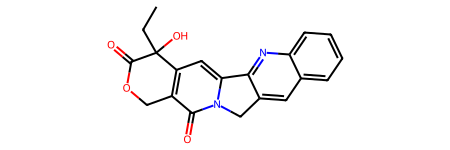

In [10]:
mol2 = smiles_to_mol(drug_smiles["Camptothecin"])
mol2

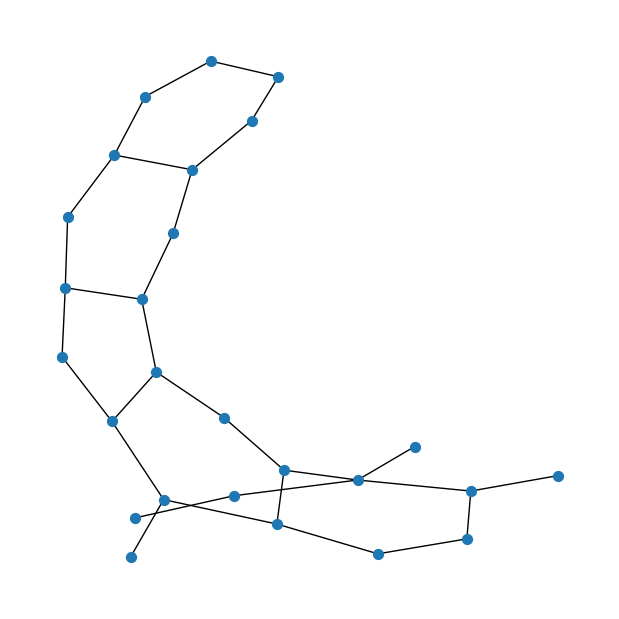

In [11]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

G = to_networkx(dataset[0], to_undirected=True)
plt.figure(figsize=(6,6))
nx.draw(G, node_size=50)
plt.show()


In [12]:
print(dataset[0].x.shape)
print(dataset[0].edge_index.shape)

torch.Size([26, 30])
torch.Size([2, 60])


In [13]:
print(len(dataset[0].x[0]))
print(len(dataset[0].edge_index[0]))

30
60


In [14]:
print(dataset[100])

Data(x=[39, 30], edge_index=[2, 86], drug_name='Epirubicin')


# Preparing the Dataset

In [15]:
# Load merged GDSC dataset with drug, cell line, IC50, and SMILES
df = pd.read_csv("dataset/GDSC_SMILES_merged.csv", index_col=0)
df = df.dropna(subset=["SMILES"])

# Load GSVA matrix (rows = cell line, cols = pathways OR vice versa)
gsva_df = pd.read_csv("dataset/ccle_gsva_scores.csv", index_col=0)


In [16]:
df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O


In [17]:
cell_lines_available = set(gsva_df.columns)

In [18]:
# Normalize IC50 if needed
df["LN_IC50"] = df["LN_IC50"].astype(float)
df["IC50_NORMALIZED"] = 1 / (1 + (1/(np.exp(df["LN_IC50"])**0.1)) )

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199501 entries, 0 to 242035
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DRUG_ID          199501 non-null  int64  
 1   DRUG_NAME        199501 non-null  object 
 2   CELL_LINE_NAME   199501 non-null  object 
 3   LN_IC50          199501 non-null  float64
 4   SMILES           199501 non-null  object 
 5   IC50_NORMALIZED  199501 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 10.7+ MB


In [20]:
df.describe()

,DRUG_ID,LN_IC50,IC50_NORMALIZED
count,199501.000000,199501.000000,199501.000000
mean,1542.707836,2.707180,0.566360
std,406.596728,2.823073,0.068694
min,1003.000000,-8.769011,0.293820
25%,1083.000000,1.353548,0.533787
50%,1583.000000,3.171952,0.578641
75%,1912.000000,4.656668,0.614358
max,2499.000000,13.107465,0.787638


In [21]:
df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,IC50_NORMALIZED
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.463511
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.380614
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.416765
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.376483
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.407536
...,...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O,0.733695
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O,0.702150
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O,0.741172
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O,0.744624


In [22]:
cell_lines_obs = set(df["CELL_LINE_NAME"].unique())

In [23]:
print("GDSC df cell lines:", df["CELL_LINE_NAME"].unique()[:5])
print("GSVA df index:", gsva_df.columns[:5])

GDSC df cell lines: ['PFSK-1' 'A673' 'ES5' 'ES7' 'EW-11']
GSVA df index: Index(['X22RV1_PROSTATE', 'X2313287_STOMACH', 'X253JBV_URINARY_TRACT',
       'X253J_URINARY_TRACT', 'X42MGBA_CENTRAL_NERVOUS_SYSTEM'],
      dtype='object')


In [24]:
# Normalize GDSC
df["CELL_LINE_NAME"] = df["CELL_LINE_NAME"].str.strip().str.upper()
cell_lines_obs = set(df["CELL_LINE_NAME"].unique())

# Normalize GSVA
gsva_df.columns = gsva_df.columns.str.strip().str.upper()
cell_lines_available = sorted(set(gsva_df.columns.str.split("_").str[0].str.upper()))

In [25]:
common_cell_lines = cell_lines_obs.intersection(cell_lines_available)
print("Now common cell lines:", len(common_cell_lines))

Now common cell lines: 133


In [26]:
len(cell_lines_obs)

969

In [27]:
cell_lines_obs

{'22RV1',
 '23132-87',
 '42-MG-BA',
 '451LU',
 '5637',
 '639-V',
 '647-V',
 '697',
 '769-P',
 '786-0',
 '8-MG-BA',
 '8305C',
 '8505C',
 'A101D',
 'A172',
 'A204',
 'A2058',
 'A253',
 'A2780',
 'A3-KAW',
 'A375',
 'A388',
 'A4-FUK',
 'A427',
 'A431',
 'A498',
 'A549',
 'A673',
 'A704',
 'ABC-1',
 'ACHN',
 'AGS',
 'ALL-PO',
 'ALL-SIL',
 'AM-38',
 'AMO-1',
 'AN3-CA',
 'ARH-77',
 'ASH-3',
 'ASPC-1',
 'ATN-1',
 'AU565',
 'B-CPAP',
 'BALL-1',
 'BB30-HNC',
 'BB49-HNC',
 'BB65-RCC',
 'BC-1',
 'BC-3',
 'BE-13',
 'BE2-M17',
 'BECKER',
 'BEN',
 'BFTC-905',
 'BFTC-909',
 'BHT-101',
 'BHY',
 'BICR10',
 'BICR22',
 'BICR31',
 'BICR78',
 'BL-41',
 'BONNA-12',
 'BPH-1',
 'BT-20',
 'BT-474',
 'BT-483',
 'BT-549',
 'BV-173',
 'BXPC-3',
 'C-33-A',
 'C-4-I',
 'C2BBE1',
 'C32',
 'C3A',
 'CA-SKI',
 'CA46',
 'CA9-22',
 'CADO-ES1',
 'CAKI-1',
 'CAL-120',
 'CAL-12T',
 'CAL-148',
 'CAL-27',
 'CAL-29',
 'CAL-33',
 'CAL-39',
 'CAL-51',
 'CAL-54',
 'CAL-62',
 'CAL-72',
 'CAL-78',
 'CAL-85-1',
 'CALU-3',
 'CALU-6',


In [28]:
cell_lines_available[:10]

['A101D',
 'A1207',
 'A172',
 'A204',
 'A2058',
 'A253',
 'A2780',
 'A375',
 'A3KAW',
 'A427']

In [29]:
import re

def clean_name(name):
    return re.sub(r'[^A-Za-z0-9]', '', name).upper()

In [30]:
cell_lines_available = {clean_name(name) for name in cell_lines_available}
cell_lines_obs = {clean_name(name) for name in cell_lines_obs}

In [31]:
common_cell_lines = cell_lines_obs.intersection(cell_lines_available)
print("Common cell lines:", len(common_cell_lines))

Common cell lines: 607


In [32]:
df["CELL_LINE_NAME_CLEAN"] = df["CELL_LINE_NAME"].apply(clean_name)
df = df[df["CELL_LINE_NAME_CLEAN"].isin(common_cell_lines)]

In [33]:
df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,IC50_NORMALIZED,CELL_LINE_NAME_CLEAN
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.380614,A673
5,1003,Camptothecin,SK-ES-1,-5.143017,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.374186,SKES1
6,1003,Camptothecin,COLO-829,-1.230277,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.469282,COLO829
8,1003,Camptothecin,RT4,-2.962875,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.426465,RT4
9,1003,Camptothecin,SW780,-1.447051,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.463887,SW780
...,...,...,...,...,...,...,...
242030,2499,N-acetyl cysteine,MM1S,9.320173,CC(=O)NC(CS)C(=O)O,0.717484,MM1S
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O,0.733695,SNU175
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O,0.702150,SNU407
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O,0.741172,SNU61


In [34]:
len(cell_lines_available)

1018

In [35]:
gsva_df

,X22RV1_PROSTATE,X2313287_STOMACH,X253JBV_URINARY_TRACT,X253J_URINARY_TRACT,X42MGBA_CENTRAL_NERVOUS_SYSTEM,X5637_URINARY_TRACT,X59M_OVARY,X639V_URINARY_TRACT,X647V_URINARY_TRACT,X697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.244789,-0.083931,0.279529,0.208577,-0.132328,0.215197,0.319143,-0.075647,0.277187,0.271370,...,0.075112,0.327630,-0.375213,-0.355703,-0.101719,-0.530021,-0.537348,0.275503,0.526732,0.220102
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.232631,0.414819,0.290806,0.670978,-0.274907,0.192912,0.640286,-0.506128,-0.057853,-0.455609,...,-0.274736,0.131784,0.551961,0.211546,-0.032558,0.151900,0.317689,-0.332108,-0.430653,0.182114
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.186705,0.177009,-0.414291,-0.038181,0.207581,0.134153,0.586046,-0.158105,-0.045624,-0.519046,...,-0.145654,0.178017,0.254041,-0.116195,-0.179142,0.231483,0.155220,0.205721,-0.166378,0.045039
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.540508,-0.258760,-0.138647,0.146632,-0.384697,-0.019662,0.407990,-0.288576,-0.125966,0.616469,...,0.087120,-0.160979,0.192224,0.457628,0.006197,-0.417248,-0.453304,-0.136213,0.387118,0.503203
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.166025,0.121127,-0.259766,-0.369504,0.117981,0.406653,-0.132804,0.414331,0.543123,-0.071814,...,0.112035,0.091719,-0.332850,0.156438,-0.064297,0.338911,0.224560,0.143953,0.002501,0.102778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.117058,0.534826,0.499067,0.476963,0.491432,-0.041223,-0.021224,-0.637564,-0.262915,-0.128982,...,-0.316305,-0.194693,0.727817,0.157373,0.250761,-0.209867,0.035322,0.055748,0.194295,0.100961
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.071946,-0.235064,-0.158232,-0.471312,0.069451,0.552709,-0.219726,-0.231657,0.247514,0.479034,...,0.471183,0.543891,0.173360,0.325866,0.628831,0.454693,0.169221,0.040660,-0.249230,-0.453372
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,-0.288375,-0.230789,-0.043607,-0.100954,-0.003728,0.443881,-0.040789,-0.123535,0.551131,0.003992,...,-0.070541,0.065449,0.058856,0.208207,0.303945,0.378906,0.233616,0.152003,-0.139507,-0.157565
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.566128,-0.454890,0.398130,0.312828,0.524678,0.477288,0.634019,-0.273644,0.437712,0.101343,...,0.100011,-0.227126,0.728999,0.366406,0.542634,-0.223423,0.224992,0.234498,-0.452274,-0.463809


In [36]:
gsva_df.columns = gsva_df.columns.str.split("_").str[0].str.upper().to_series().apply(clean_name)
gsva_df.columns.has_duplicates

True

In [37]:
gsva_df = gsva_df.loc[:, ~gsva_df.columns.duplicated()]
print(gsva_df.columns.has_duplicates)
gsva_df

False


,X22RV1,X2313287,X253JBV,X253J,X42MGBA,X5637,X59M,X639V,X647V,X697,...,WSUDLCL2,YAPC,YD10B,YD15,YD38,YD8,YH13,YKG1,ZR751,ZR7530
KEGG_MEDICUS_ENV_FACTOR_ARSENIC_TO_ELECTRON_TRANSFER_IN_COMPLEX_IV,0.244789,-0.083931,0.279529,0.208577,-0.132328,0.215197,0.319143,-0.075647,0.277187,0.271370,...,0.075112,0.327630,-0.375213,-0.355703,-0.101719,-0.530021,-0.537348,0.275503,0.526732,0.220102
KEGG_MEDICUS_ENV_FACTOR_BENZO_A_PYRENRE_TO_CYP_MEDIATED_METABOLISM,0.232631,0.414819,0.290806,0.670978,-0.274907,0.192912,0.640286,-0.506128,-0.057853,-0.455609,...,-0.274736,0.131784,0.551961,0.211546,-0.032558,0.151900,0.317689,-0.332108,-0.430653,0.182114
KEGG_MEDICUS_ENV_FACTOR_DCE_TO_DNA_ADDUCTS,-0.186705,0.177009,-0.414291,-0.038181,0.207581,0.134153,0.586046,-0.158105,-0.045624,-0.519046,...,-0.145654,0.178017,0.254041,-0.116195,-0.179142,0.231483,0.155220,0.205721,-0.166378,0.045039
KEGG_MEDICUS_ENV_FACTOR_E2_TO_NUCLEAR_INITIATED_ESTROGEN_SIGNALING_PATHWAY,-0.540508,-0.258760,-0.138647,0.146632,-0.384697,-0.019662,0.407990,-0.288576,-0.125966,0.616469,...,0.087120,-0.160979,0.192224,0.457628,0.006197,-0.417248,-0.453304,-0.136213,0.387118,0.503203
KEGG_MEDICUS_ENV_FACTOR_E2_TO_RAS_ERK_SIGNALING_PATHWAY,-0.166025,0.121127,-0.259766,-0.369504,0.117981,0.406653,-0.132804,0.414331,0.543123,-0.071814,...,0.112035,0.091719,-0.332850,0.156438,-0.064297,0.338911,0.224560,0.143953,0.002501,0.102778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KEGG_MEDICUS_VARIANT_SCRAPIE_CONFORMATION_PRPSC_TO_VGCC_CA2_APOPTOTIC_PATHWAY,-0.117058,0.534826,0.499067,0.476963,0.491432,-0.041223,-0.021224,-0.637564,-0.262915,-0.128982,...,-0.316305,-0.194693,0.727817,0.157373,0.250761,-0.209867,0.035322,0.055748,0.194295,0.100961
KEGG_MEDICUS_VARIANT_TEL_AML1_FUSION_TO_TRANSCRIPTIONAL_REPRESSION,-0.071946,-0.235064,-0.158232,-0.471312,0.069451,0.552709,-0.219726,-0.231657,0.247514,0.479034,...,0.471183,0.543891,0.173360,0.325866,0.628831,0.454693,0.169221,0.040660,-0.249230,-0.453372
KEGG_MEDICUS_VARIANT_TGFA_OVEREXPRESSION_TO_PI3K_SIGNALING_PATHWAY,-0.288375,-0.230789,-0.043607,-0.100954,-0.003728,0.443881,-0.040789,-0.123535,0.551131,0.003992,...,-0.070541,0.065449,0.058856,0.208207,0.303945,0.378906,0.233616,0.152003,-0.139507,-0.157565
KEGG_MEDICUS_VARIANT_TMPRSS2_ERG_FUSION_TO_TRANSCRIPTIONAL_ACTIVATION,-0.566128,-0.454890,0.398130,0.312828,0.524678,0.477288,0.634019,-0.273644,0.437712,0.101343,...,0.100011,-0.227126,0.728999,0.366406,0.542634,-0.223423,0.224992,0.234498,-0.452274,-0.463809


# Building the PyTorch Dataset

In [38]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class DrugResponseDataset(Dataset):
    def __init__(self, dataframe, gsva_df, drug_smiles, atom_vocab):
        self.df = dataframe.reset_index(drop=True)
        self.gsva_df = gsva_df
        self.drug_smiles = drug_smiles
        self.atom_vocab = atom_vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug = row["DRUG_NAME"]
        cell_line = row["CELL_LINE_NAME_CLEAN"]
        y = row["IC50_NORMALIZED"]

        if drug not in self.drug_smiles:
            raise ValueError(f"Drug '{drug}' not found in SMILES dictionary")

        smi = self.drug_smiles[drug]
        mol = smiles_to_mol(smi)

        if mol is None:
            raise ValueError(f"Invalid SMILES for {drug}: {smi}")

        graph = mol_to_graph_data_obj(mol)
        graph.idx = idx

        if cell_line not in self.gsva_df.columns:
            raise ValueError(f"Cell line '{cell_line}' not in GSVA")

        gsva_vec = torch.tensor(self.gsva_df[cell_line].values, dtype=torch.float)
        return graph, gsva_vec, torch.tensor([y], dtype=torch.float)


In [39]:
from torch_geometric.loader import DataLoader as PyGLoader
from torch.utils.data import DataLoader as TorchLoader
from torch_geometric.data import Batch

# Custom collate to combine graph batches + tensor batches
def collate_fn(batch):
    graphs, gsvectors, targets = zip(*batch)
    return (
        Batch.from_data_list(graphs),
        torch.stack(gsvectors),
        torch.stack(targets)
    )

In [40]:
from sklearn.model_selection import train_test_split

cell_lines = df["CELL_LINE_NAME_CLEAN"].unique()
train_cl, temp_cl = train_test_split(cell_lines, test_size=0.3, random_state=42)
val_cl, test_cl = train_test_split(temp_cl, test_size=2/3, random_state=42)

In [41]:
train_df = df[df["CELL_LINE_NAME_CLEAN"].isin(train_cl)]
val_df   = df[df["CELL_LINE_NAME_CLEAN"].isin(val_cl)]
test_df  = df[df["CELL_LINE_NAME_CLEAN"].isin(test_cl)]

In [42]:
train_dataset = DrugResponseDataset(train_df, gsva_df, drug_smiles, atom_vocab)
val_dataset   = DrugResponseDataset(val_df, gsva_df, drug_smiles, atom_vocab)
test_dataset  = DrugResponseDataset(test_df, gsva_df, drug_smiles, atom_vocab)

In [43]:
train_loader = TorchLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = TorchLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = TorchLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [44]:
# train_dataset = DrugResponseDataset(df, gsva_df, drug_smiles, atom_vocab)
# train_loader = TorchLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Building the Model Architecture

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_max_pool
from torch_geometric.data import Data

from tqdm.notebook import tqdm

from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

In [46]:
class DrugGINEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, out_dim=128):
        super().__init__()

        # MLPs for GIN layers
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gin1 = GINConv(self.mlp1)

        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gin2 = GINConv(self.mlp2)

        self.fc = nn.Linear(hidden_dim, out_dim)  # Final output: 128-dim

    def forward(self, x, edge_index, batch):
        x = self.gin1(x, edge_index)
        x = F.relu(x)
        x = self.gin2(x, edge_index)
        x = F.relu(x)

        # Global pooling to get graph-level embedding
        x = global_max_pool(x, batch)

        # Final FC layer
        x = self.fc(x)
        return x

In [47]:
class CellLineEncoder(nn.Module):
    def __init__(self, input_dim=658): # gsva_vector.shape = (658,)
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(1024, 128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [48]:
dataset[0]

Data(x=[26, 30], edge_index=[2, 60], drug_name='Camptothecin')

In [49]:
class GPDRPModel(nn.Module):
    def __init__(self, drug_in_dim=30, gsva_dim=658):
        super().__init__()
        self.drug_encoder = DrugGINEncoder(drug_in_dim)
        self.cell_encoder = CellLineEncoder(gsva_dim)
        self.fc = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # final IC50 prediction
        )

    def forward(self, data, gsva):
        drug_repr = self.drug_encoder(data.x, data.edge_index, data.batch)
        cell_repr = self.cell_encoder(gsva)
        fused = torch.cat([drug_repr, cell_repr], dim=1)
        return self.fc(fused)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
best_rmse = float("inf")
best_model_path = "models/gpdrp_best_model.pt"

# Training

In [52]:
max_epocs = 50

model = GPDRPModel(drug_in_dim=30, gsva_dim=658).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=max_epocs, eta_min=1e-6)
loss_fn = nn.MSELoss()
train_rmses = []
val_rmses = []

for epoch in range(1, max_epocs+1):
    print(f"\n🌟 Epoch {epoch}")
    model.train()
    total_loss = 0
    preds, truths = [], []

    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for i, (graph_batch, gsva_batch, ic50_batch) in enumerate(train_bar):
        graph_batch = graph_batch.to(device)
        gsva_batch = gsva_batch.to(device)
        ic50_batch = ic50_batch.to(device)

        pred = model(graph_batch, gsva_batch)
        loss = loss_fn(pred, ic50_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(ic50_batch)

        preds.extend(pred.detach().cpu().numpy().flatten())
        truths.extend(ic50_batch.detach().cpu().numpy().flatten())

        if (i + 1) % 50 == 0:
            rmse = root_mean_squared_error(truths, preds)
            pcc = pearsonr(truths, preds)[0]
            train_bar.set_postfix({
                "Batch": i + 1,
                "Loss": loss.item(),
                "RMSE": f"{rmse:.4f}",
                "PCC": f"{pcc:.4f}"
            })

    avg_loss = total_loss / len(train_loader.dataset)
    train_rmse = root_mean_squared_error(truths, preds)
    train_pcc = pearsonr(truths, preds)[0]
    print(f"✅ Epoch {epoch}: MSE = {avg_loss:.4f}, RMSE = {train_rmse:.4f}, PCC = {train_pcc:.4f}")

    # 🔍 Validation Phase
    model.eval()
    val_preds, val_truths = [], []

    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for graph_batch, gsva_batch, ic50_batch in val_bar:
            graph_batch = graph_batch.to(device)
            gsva_batch = gsva_batch.to(device)
            ic50_batch = ic50_batch.to(device)

            pred = model(graph_batch, gsva_batch)
            val_preds.extend(pred.cpu().numpy().flatten())
            val_truths.extend(ic50_batch.cpu().numpy().flatten())

    val_rmse = root_mean_squared_error(val_truths, val_preds)
    val_pcc = pearsonr(val_truths, val_preds)[0]
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"📉 Val RMSE = {val_rmse:.4f} | LR = {current_lr:.1e}")


    if val_rmse < best_rmse:
        best_rmse = val_rmse
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved new best model (RMSE: {val_rmse:.4f})")
    
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)



🌟 Epoch 1


✅ Epoch 1: MSE = 0.0020, RMSE = 0.0448, PCC = 0.7618


📉 Val RMSE = 0.0495 | LR = 1.0e-03
✅ Saved new best model (RMSE: 0.0495)

🌟 Epoch 2


✅ Epoch 2: MSE = 0.0013, RMSE = 0.0354, PCC = 0.8562


📉 Val RMSE = 0.0377 | LR = 1.0e-03
✅ Saved new best model (RMSE: 0.0377)

🌟 Epoch 3


✅ Epoch 3: MSE = 0.0012, RMSE = 0.0340, PCC = 0.8679


📉 Val RMSE = 0.0368 | LR = 9.9e-04
✅ Saved new best model (RMSE: 0.0368)

🌟 Epoch 4


✅ Epoch 4: MSE = 0.0011, RMSE = 0.0330, PCC = 0.8758


📉 Val RMSE = 0.0366 | LR = 9.8e-04
✅ Saved new best model (RMSE: 0.0366)

🌟 Epoch 5


✅ Epoch 5: MSE = 0.0011, RMSE = 0.0326, PCC = 0.8795


📉 Val RMSE = 0.0357 | LR = 9.8e-04
✅ Saved new best model (RMSE: 0.0357)

🌟 Epoch 6


✅ Epoch 6: MSE = 0.0010, RMSE = 0.0319, PCC = 0.8843


📉 Val RMSE = 0.0363 | LR = 9.6e-04

🌟 Epoch 7


✅ Epoch 7: MSE = 0.0010, RMSE = 0.0316, PCC = 0.8870


📉 Val RMSE = 0.0372 | LR = 9.5e-04

🌟 Epoch 8


✅ Epoch 8: MSE = 0.0010, RMSE = 0.0312, PCC = 0.8898


📉 Val RMSE = 0.0366 | LR = 9.4e-04

🌟 Epoch 9


✅ Epoch 9: MSE = 0.0010, RMSE = 0.0309, PCC = 0.8921


📉 Val RMSE = 0.0357 | LR = 9.2e-04

🌟 Epoch 10


✅ Epoch 10: MSE = 0.0009, RMSE = 0.0306, PCC = 0.8947


📉 Val RMSE = 0.0354 | LR = 9.0e-04
✅ Saved new best model (RMSE: 0.0354)

🌟 Epoch 11


✅ Epoch 11: MSE = 0.0009, RMSE = 0.0303, PCC = 0.8965


📉 Val RMSE = 0.0370 | LR = 8.9e-04

🌟 Epoch 12


✅ Epoch 12: MSE = 0.0009, RMSE = 0.0299, PCC = 0.8993


📉 Val RMSE = 0.0358 | LR = 8.6e-04

🌟 Epoch 13


✅ Epoch 13: MSE = 0.0009, RMSE = 0.0297, PCC = 0.9008


📉 Val RMSE = 0.0352 | LR = 8.4e-04
✅ Saved new best model (RMSE: 0.0352)

🌟 Epoch 14


✅ Epoch 14: MSE = 0.0009, RMSE = 0.0294, PCC = 0.9032


📉 Val RMSE = 0.0345 | LR = 8.2e-04
✅ Saved new best model (RMSE: 0.0345)

🌟 Epoch 15


✅ Epoch 15: MSE = 0.0008, RMSE = 0.0290, PCC = 0.9056


📉 Val RMSE = 0.0352 | LR = 7.9e-04

🌟 Epoch 16


✅ Epoch 16: MSE = 0.0008, RMSE = 0.0287, PCC = 0.9075


📉 Val RMSE = 0.0349 | LR = 7.7e-04

🌟 Epoch 17


✅ Epoch 17: MSE = 0.0008, RMSE = 0.0285, PCC = 0.9091


📉 Val RMSE = 0.0360 | LR = 7.4e-04

🌟 Epoch 18


✅ Epoch 18: MSE = 0.0008, RMSE = 0.0283, PCC = 0.9103


📉 Val RMSE = 0.0349 | LR = 7.1e-04

🌟 Epoch 19


✅ Epoch 19: MSE = 0.0008, RMSE = 0.0281, PCC = 0.9118


📉 Val RMSE = 0.0353 | LR = 6.8e-04

🌟 Epoch 20


✅ Epoch 20: MSE = 0.0008, RMSE = 0.0279, PCC = 0.9131


📉 Val RMSE = 0.0352 | LR = 6.5e-04

🌟 Epoch 21


✅ Epoch 21: MSE = 0.0008, RMSE = 0.0277, PCC = 0.9143


📉 Val RMSE = 0.0354 | LR = 6.2e-04

🌟 Epoch 22


✅ Epoch 22: MSE = 0.0008, RMSE = 0.0275, PCC = 0.9158


📉 Val RMSE = 0.0349 | LR = 5.9e-04

🌟 Epoch 23


✅ Epoch 23: MSE = 0.0007, RMSE = 0.0274, PCC = 0.9165


📉 Val RMSE = 0.0347 | LR = 5.6e-04

🌟 Epoch 24


✅ Epoch 24: MSE = 0.0007, RMSE = 0.0271, PCC = 0.9181


📉 Val RMSE = 0.0349 | LR = 5.3e-04

🌟 Epoch 25


✅ Epoch 25: MSE = 0.0007, RMSE = 0.0270, PCC = 0.9190


📉 Val RMSE = 0.0346 | LR = 5.0e-04

🌟 Epoch 26


✅ Epoch 26: MSE = 0.0007, RMSE = 0.0268, PCC = 0.9201


📉 Val RMSE = 0.0352 | LR = 4.7e-04

🌟 Epoch 27


✅ Epoch 27: MSE = 0.0007, RMSE = 0.0266, PCC = 0.9211


📉 Val RMSE = 0.0351 | LR = 4.4e-04

🌟 Epoch 28


✅ Epoch 28: MSE = 0.0007, RMSE = 0.0265, PCC = 0.9222


📉 Val RMSE = 0.0351 | LR = 4.1e-04

🌟 Epoch 29


✅ Epoch 29: MSE = 0.0007, RMSE = 0.0262, PCC = 0.9236


📉 Val RMSE = 0.0350 | LR = 3.8e-04

🌟 Epoch 30


✅ Epoch 30: MSE = 0.0007, RMSE = 0.0260, PCC = 0.9250


📉 Val RMSE = 0.0355 | LR = 3.5e-04

🌟 Epoch 31


✅ Epoch 31: MSE = 0.0007, RMSE = 0.0258, PCC = 0.9260


📉 Val RMSE = 0.0350 | LR = 3.2e-04

🌟 Epoch 32


✅ Epoch 32: MSE = 0.0007, RMSE = 0.0257, PCC = 0.9268


📉 Val RMSE = 0.0349 | LR = 2.9e-04

🌟 Epoch 33


✅ Epoch 33: MSE = 0.0006, RMSE = 0.0255, PCC = 0.9280


📉 Val RMSE = 0.0348 | LR = 2.6e-04

🌟 Epoch 34


✅ Epoch 34: MSE = 0.0006, RMSE = 0.0254, PCC = 0.9287


📉 Val RMSE = 0.0351 | LR = 2.3e-04

🌟 Epoch 35


✅ Epoch 35: MSE = 0.0006, RMSE = 0.0252, PCC = 0.9298


📉 Val RMSE = 0.0349 | LR = 2.1e-04

🌟 Epoch 36


✅ Epoch 36: MSE = 0.0006, RMSE = 0.0249, PCC = 0.9311


📉 Val RMSE = 0.0347 | LR = 1.8e-04

🌟 Epoch 37


✅ Epoch 37: MSE = 0.0006, RMSE = 0.0248, PCC = 0.9320


📉 Val RMSE = 0.0348 | LR = 1.6e-04

🌟 Epoch 38


✅ Epoch 38: MSE = 0.0006, RMSE = 0.0247, PCC = 0.9327


📉 Val RMSE = 0.0346 | LR = 1.4e-04

🌟 Epoch 39


✅ Epoch 39: MSE = 0.0006, RMSE = 0.0245, PCC = 0.9337


📉 Val RMSE = 0.0348 | LR = 1.2e-04

🌟 Epoch 40


✅ Epoch 40: MSE = 0.0006, RMSE = 0.0243, PCC = 0.9346


📉 Val RMSE = 0.0347 | LR = 9.6e-05

🌟 Epoch 41


✅ Epoch 41: MSE = 0.0006, RMSE = 0.0242, PCC = 0.9354


📉 Val RMSE = 0.0346 | LR = 7.9e-05

🌟 Epoch 42


✅ Epoch 42: MSE = 0.0006, RMSE = 0.0241, PCC = 0.9358


📉 Val RMSE = 0.0346 | LR = 6.3e-05

🌟 Epoch 43


✅ Epoch 43: MSE = 0.0006, RMSE = 0.0240, PCC = 0.9366


📉 Val RMSE = 0.0347 | LR = 4.9e-05

🌟 Epoch 44


✅ Epoch 44: MSE = 0.0006, RMSE = 0.0239, PCC = 0.9369


📉 Val RMSE = 0.0347 | LR = 3.6e-05

🌟 Epoch 45


✅ Epoch 45: MSE = 0.0006, RMSE = 0.0238, PCC = 0.9376


📉 Val RMSE = 0.0345 | LR = 2.5e-05

🌟 Epoch 46


✅ Epoch 46: MSE = 0.0006, RMSE = 0.0237, PCC = 0.9380


📉 Val RMSE = 0.0346 | LR = 1.7e-05

🌟 Epoch 47


✅ Epoch 47: MSE = 0.0006, RMSE = 0.0237, PCC = 0.9380


📉 Val RMSE = 0.0346 | LR = 9.8e-06

🌟 Epoch 48


✅ Epoch 48: MSE = 0.0006, RMSE = 0.0237, PCC = 0.9383


📉 Val RMSE = 0.0346 | LR = 4.9e-06

🌟 Epoch 49


✅ Epoch 49: MSE = 0.0006, RMSE = 0.0236, PCC = 0.9385


📉 Val RMSE = 0.0346 | LR = 2.0e-06

🌟 Epoch 50


✅ Epoch 50: MSE = 0.0006, RMSE = 0.0237, PCC = 0.9383


📉 Val RMSE = 0.0346 | LR = 1.0e-06


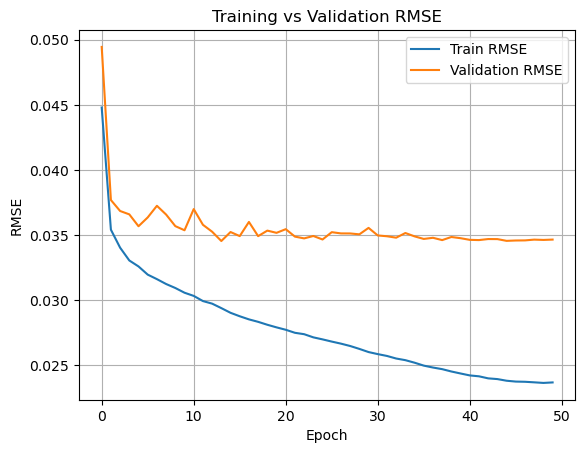

In [53]:
import matplotlib.pyplot as plt

plt.plot(train_rmses, label="Train RMSE")
plt.plot(val_rmses, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.show()

# Testing and Evaluation

In [54]:
best_model = GPDRPModel(drug_in_dim=30, gsva_dim=658).to(device)
best_model.load_state_dict(torch.load("models/gpdrp_best_model.pt"))
best_model.eval()

/tmp/ipykernel_75776/2176663123.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("models/gpdrp_best_model.pt"))


GPDRPModel(
  (drug_encoder): DrugGINEncoder(
    (mlp1): Sequential(
      (0): Linear(in_features=30, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (gin1): GINConv(nn=Sequential(
      (0): Linear(in_features=30, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (mlp2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
    (gin2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
    (fc): Linear(in_features=64, out_features=128, bias=True)
  )
  (cell_encoder): CellLineEncoder(
    (fc1): Linear(in_features=658, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (dropout

In [55]:
test_preds, test_truths = [], []

with torch.no_grad():
    for graph_batch, gsva_batch, ic50_batch in tqdm(test_loader, desc="Testing"):
        graph_batch = graph_batch.to(device)
        gsva_batch = gsva_batch.to(device)
        ic50_batch = ic50_batch.to(device)

        pred = best_model(graph_batch, gsva_batch)
        test_preds.extend(pred.cpu().numpy().flatten())
        test_truths.extend(ic50_batch.cpu().numpy().flatten())


In [56]:
test_rmse = root_mean_squared_error(test_truths, test_preds)
test_pcc = pearsonr(test_truths, test_preds)[0]

print(f"🧪 Test RMSE: {test_rmse:.4f}")
print(f"🧪 Test PCC:  {test_pcc:.4f}")


🧪 Test RMSE: 0.0351
🧪 Test PCC:  0.8622


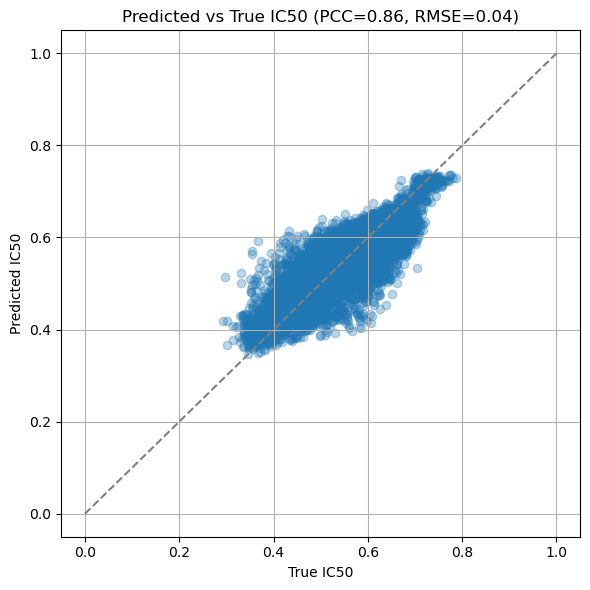

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(test_truths, test_preds, alpha=0.3)
plt.xlabel("True IC50")
plt.ylabel("Predicted IC50")
plt.title(f"Predicted vs True IC50 (PCC={test_pcc:.2f}, RMSE={test_rmse:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')  # line y=x
plt.grid(True)
plt.tight_layout()
plt.show()